In [1]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
import retro_prepare
import matplotlib.colors

In [2]:
patient_id = 'id001_bt'
data_dir = f'/home/hfw/Retro/datasets/{patient_id}'
results_dir = f'/home/hfw/Retro/results/{patient_id}'
szr_name = 'BTcrise2appportable_0013'
#szr_name = 'BTcrise1appportable_0006'
meta_data_fname = f'{szr_name}.json'
#raw_seeg_fname = f'{szr_name}.raw.fif'
fname_suffix = f'{szr_name}'
# if os.path.isdir(results_dir):
#     os.rmdir(results_dir)
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)
os.makedirs(f'{results_dir}/Rfiles', exist_ok=True)

In [3]:
hpf = 10
lpf = 0.02
raw_seeg_fname = f'{szr_name}.raw.fif'
#data_mono = retro_prepare_data.prepare_data(data_dir, meta_data_fname, raw_seeg_fname, szr_name, hpf, lpf)
#raw_seeg_fname = f'{szr_name}.bip.raw.fif'
data = retro_prepare.prepare_data_bip(data_dir, meta_data_fname, raw_seeg_fname, szr_name, hpf, lpf)
#fname_suffix += f'_hpf{hpf}_lpf{lpf}'

Isotrak not found


/opt/conda/envs/jhub/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [4]:
seeg, bip = retro_prepare.read_one_seeg(data_dir, meta_data_fname, raw_seeg_fname)
slp = retro_prepare.compute_slp(seeg, bip, hpf, lpf)

Isotrak not found


In [5]:
def read_ez_sens_mask(sid, ch_names):
    xlsx_file = os.path.join(sid, "patient.xlsx")
    CONTACTS_IND = 6
    EZ_IND = 7
    df = pd.read_excel(xlsx_file, sheet_name="EZ hypothesis and EI", header=1)
    ez_contacts = []
    contacts_col = df.iloc[:, CONTACTS_IND]
    mask = contacts_col.notnull()
    contacts_names = contacts_col[mask]
    ez_mask = df.iloc[:, EZ_IND][mask] == "YES"
    ez_contacts.extend(contacts_names[ez_mask])
    # OR1-OR2 -> OR1-2
    # TODO handle the case monopolar
    ez_contacts_ = []
    cre = re.compile("([A-Za-z'p]+)([0-9]+)-([A-Za-z'p]+)([0-9]+)")
    cre_mono = re.compile("([A-Za-z'p]+)([0-9]+)")
    for ez_contact in ez_contacts:
        try:
            nm, i, _, j = cre.match(ez_contact).groups()
            ez_contacts_.append(f"{nm}{i}-{j}")
        except Exception as exc:
            try:
                nm, i = cre_mono.match(ez_contact).groups()
                ez_contacts_.append(f"{nm}{i}-{int(i)+1}")
            except Exception as exc:
                print(sid, ez_contact, exc)
                continue
    m_ez = np.array([_ in ez_contacts_ for _ in ch_names])
    return m_ez

In [6]:
import mne
import pandas as pd
import re

In [7]:
#raw = retro_prepare.load_raw_fif(meta_data_fname)
'''raw = mne.io.Raw(
                os.path.join(data_dir, 'seeg', 'fif', raw_seeg_fname),
                verbose='WARNING',
                preload=True)
'''
ezh = read_ez_sens_mask(data_dir, bip.ch_names)


/opt/conda/envs/jhub/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


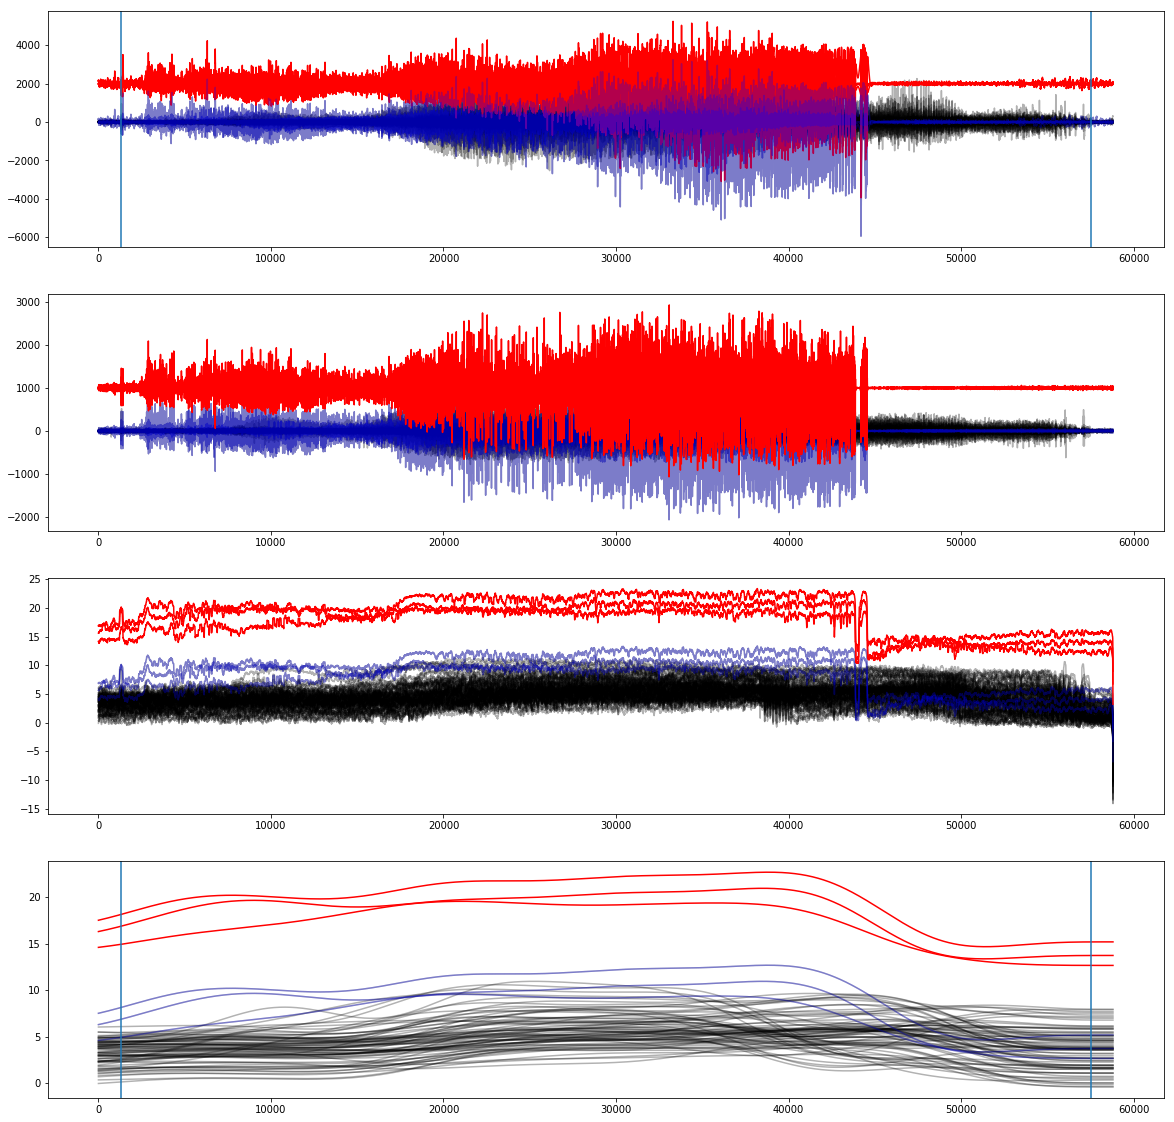

In [8]:
#seeg = retro_prepare_data.read_one_bip_seeg(data_dir, meta_data_fname, raw_seeg_fname)
ts = 5
base_length = int(seeg['sfreq']*ts)

start_idx = int(seeg['onset'] * seeg['sfreq']) - base_length
end_idx = int(seeg['offset'] * seeg['sfreq']) + base_length
slp = bip.get_data().T[start_idx:end_idx]
#slp = seeg['time_series'].copy()
# Remove outliers i.e data > 2*sd
plt.figure(figsize=(20,20))
plt.subplot(411)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh]+2000,color='red');
plt.plot(slp[:,ezh],color='blue', alpha = 0.3);
plt.axvline(int(seeg['sfreq']*ts))
plt.axvline(len(slp)-int(seeg['sfreq']*ts))


for i in range(slp.shape[1]):
    ts = slp[:, i]
    ts[abs(ts - ts.mean()) > 2 * ts.std()] = ts.mean()
# High pass filter the data
slp = lib.preprocess.envelope.bfilt(
    slp, seeg['sfreq'], hpf, 'highpass', axis=0)
plt.subplot(412)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh],color='blue',alpha = 0.3);
plt.plot(slp[:,ezh]+1000,color='red');

# Compute seeg log power
slp = lib.preprocess.envelope.seeg_log_power(slp, 100)
plt.subplot(413)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh],color='blue',alpha = 0.3);
plt.plot(slp[:,ezh]+10,color='red');

# Remove outliers i.e data > 2*sd
for i in range(slp.shape[1]):
    ts = slp[:, i]
    ts[abs(ts - ts.mean()) > 2 * ts.std()] = ts.mean()
# Low pass filter the data to smooth
slp = lib.preprocess.envelope.bfilt(
    slp, seeg['sfreq'], lpf, 'lowpass', axis=0)

plt.subplot(414)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh],color='blue',alpha = 0.3);
plt.plot(slp[:,ezh]+10,color='red');
plt.axvline(base_length)
plt.axvline(len(slp)-base_length)



In [25]:
ds_freq = int(data['slp'].shape[0]/150)
data['slp'] = data['slp'][0:-1:ds_freq]
data['snsr_pwr'] = (data['slp']**2).mean(axis=0)
data['ns'], data['nn'] = data['gain'].shape
data['nt'] = data['slp'].shape[0]
ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.vep.txt') == 1)[0]
data['x0_mu'] = -3.0*np.ones(data['nn'])
fname_suffix += 'PUni' #f'_hpf{hpf}_lpf{lpf}'
#data['x0_mu'][ez_hyp] = -1.5

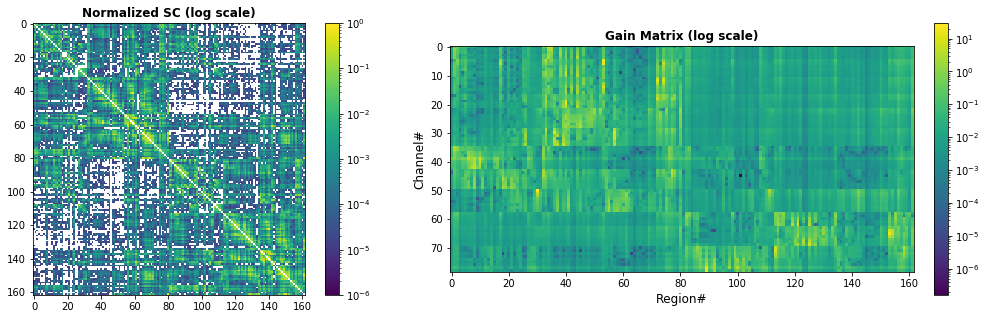

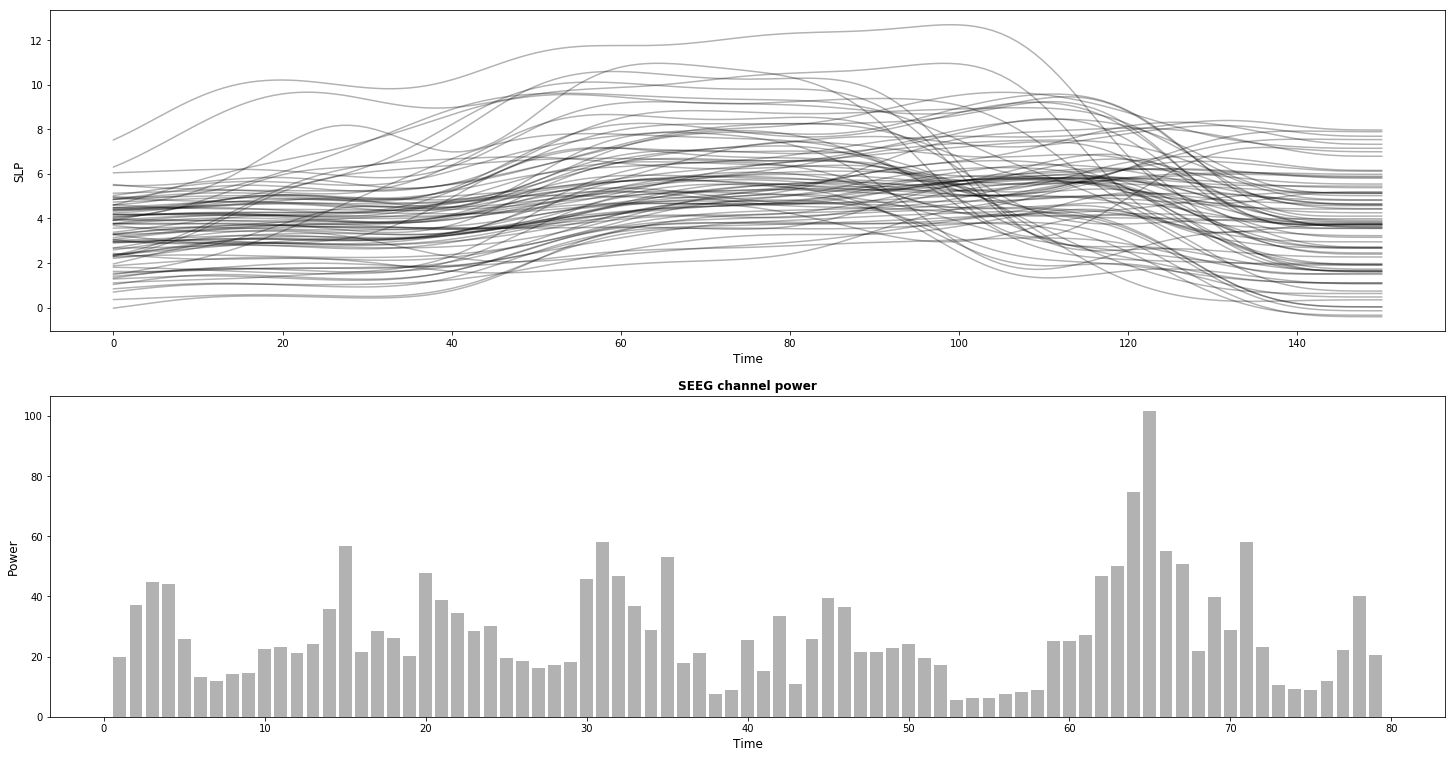

In [11]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(data['SC'],norm=matplotlib.colors.LogNorm(vmin=1e-6, vmax=data['SC'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.title('Normalized SC (log scale)',fontsize=12, fontweight='bold')

plt.subplot(122)
plt.imshow(data['gain'],norm=matplotlib.colors.LogNorm(vmin=data['gain'].min(), vmax=data['gain'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.xlabel('Region#', fontsize=12)
plt.ylabel('Channel#', fontsize=12)
plt.title('Gain Matrix (log scale)',fontsize=12, fontweight='bold')
plt.savefig(f'{results_dir}/figures/network.png')

plt.figure(figsize=(25,13))
plt.subplot(211)
plt.plot(data['slp'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('SLP', fontsize=12)

plt.subplot(212)
plt.bar(np.r_[1:data['ns']+1],data['snsr_pwr'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('SEEG channel power', fontweight='bold')
plt.savefig(f'{results_dir}/figures/fitting_target_{fname_suffix}.png')
# plt.tight_layout()


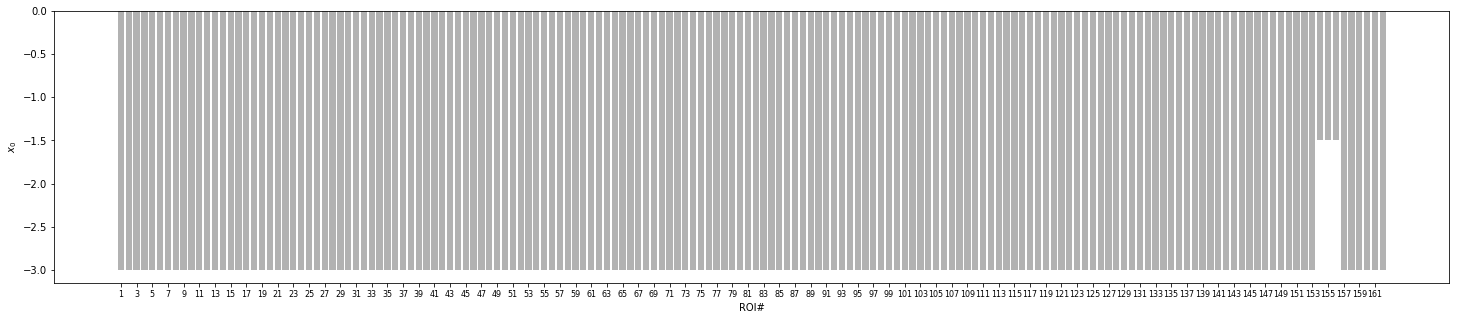

In [12]:
plt.figure(figsize=(25,5))
plt.bar(np.r_[1:data['nn']+1],data['x0_mu'], color='black', alpha=0.3)
plt.xticks(np.r_[1:data['nn']+1:2], fontsize=8);
plt.xlabel('ROI#')
plt.ylabel(r'$x_0$', fontsize=10)
plt.savefig(f'{results_dir}/figures/ez_hyp.png')

In [57]:
#stan_fname = 'vep-snsrfit-ode-nointerp'
stan_fname = 'szr_prpgtn'

x0 = data['x0_mu']
amplitude = 1.0 
offset = 0
K = 1.0
tau0 = 20
eps_slp = 1.0
eps_snsr_pwr = 1.0
x_init = -2.0*np.ones(data['nn'])
z_init = 3.5*np.ones(data['nn'])

param_init = {'x0':x0, 'amplitude':amplitude,
              'offset':offset, 'K':K, 'tau0':tau0, 'x_init':x_init, 'z_init':z_init,
              'eps_slp':eps_slp, 'eps_snsr_pwr':eps_snsr_pwr}

param_init_file = 'param_init.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R',param_init)

input_Rfile = f'fit_data_{fname_suffix}.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)

In [14]:
#%%bash -s "$stan_fname" 

#stancompile.sh $1

In [58]:
%%bash -s "$stan_fname" "$results_dir" "$input_Rfile" "$fname_suffix"

STAN_FNAME=$1
RESULTS_DIR=$2
INPUT_RFILE=$3
FNAME_SUFFIX=$4


for i in {1..4};
do
./${STAN_FNAME} optimize algorithm=lbfgs tol_param=1e-4 iter=20000 save_iterations=0  \
data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
init=${RESULTS_DIR}/Rfiles/param_init.R \
output file=${RESULTS_DIR}/samples_${FNAME_SUFFIX}_chain${i}.csv refresh=10 \
&> ${RESULTS_DIR}/logs/snsrfit_ode_${FNAME_SUFFIX}_chain${i}.log &
done

In [46]:
vep_smax = np.zeros(ns)
for ibip_elec, indroi_iv in zip(bip.ch_names,np.argmax(data['gain'],axis=1)):
   
    print(ibip_elec, ': ', roi[indroi_iv])

TP'1-2 :  Left-Temporal-pole
TP'4-5 :  Left-T1-planum-polare
TP'5-6 :  Left-T1-lateral-anterior
TP'6-7 :  Left-Temporal-pole
TP'7-8 :  Left-T2-anterior
A'1-2 :  Left-Rhinal-cortex
A'2-3 :  Left-Rhinal-cortex
A'5-6 :  Left-Amygdala
A'6-7 :  Left-STS-anterior
A'7-8 :  Left-STS-anterior
A'8-9 :  Left-STS-anterior
TB'1-2 :  Left-Amygdala
TB'2-3 :  Left-Hippocampus-anterior
TB'3-4 :  Left-Amygdala
TB'6-7 :  Left-Rhinal-cortex
TB'7-8 :  Left-Rhinal-cortex
TB'8-9 :  Left-T2-anterior
B'1-2 :  Left-Hippocampus-anterior
B'2-3 :  Left-Hippocampus-anterior
B'6-7 :  Left-STS-anterior
B'7-8 :  Left-STS-anterior
B'8-9 :  Left-STS-anterior
GPH'1-2 :  Left-Cerebellar-cortex
GPH'2-3 :  Left-Collateral-sulcus
GPH'6-7 :  Left-STS-anterior
GPH'7-8 :  Left-STS-anterior
GPH'8-9 :  Left-T2-posterior
GPH'9-10 :  Left-T2-posterior
GPH'10-11 :  Left-T2-posterior
H'1-2 :  Left-Insula-gyri-longi
H'2-3 :  Left-Gyrus-of-Heschl
H'5-6 :  Left-Supramarginal-anterior
H'6-7 :  Left-Supramarginal-anterior
H'7-8 :  Left-Gy

In [8]:
pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain1.csv'])

print(pstr_samples['x0'],pstr_samples['tau0'])

[[-2.98754 -1.55161 -3.00739 -3.03805 -2.97118 -2.86207 -3.36664 -3.38168
  -1.91926 -3.14188 -3.49684 -2.85863 -2.97161 -3.00852 -3.03593 -3.10051
  -2.95912 -3.84438 -1.55978 -2.46182 -2.95883 -2.60804 -2.84422 -3.06625
  -3.08904 -2.91854 -2.64751 -3.03448 -2.99009 -3.10192 -5.29449 -3.02959
  -2.73334 -3.63822 -2.7775  -1.8586  -2.88829 -2.93634 -1.1515  -2.37633
  -2.13685 -3.60884 -2.31316 -3.03255 -1.86339 -3.27791 -2.34754 -2.92756
  -2.84638 -2.76924 -1.42495 -2.96639 -1.96922 -5.16695 -3.11391 -4.12934
  -3.10246 -1.46315 -3.45178 -3.27205 -3.37722 -3.5764  -3.26609 -3.06617
  -3.00234 -2.96629 -3.00644 -3.01201 -2.97688 -2.85564 -2.99942 -3.04247
  -2.73606 -2.86439 -3.52806 -2.67632 -3.04869 -1.04153 -2.66329 -3.02752
  -1.58749 -3.00418 -2.97089 -2.96323 -3.00068 -3.01154 -2.59979 -3.02835
  -2.94472 -2.49683 -2.95918 -2.95159 -2.02765 -2.98077 -2.99888 -3.03
  -2.9811  -2.79421 -2.99279 -3.07121 -2.89109 -2.92484 -2.85811 -2.96175
  -3.10676 -3.08041 -2.95789 -2.99964 -3.

In [10]:

chains = [1,2,3,4]
for i,chain_no in enumerate(chains):
    pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{chain_no}.csv'])

    print(pstr_samples['x0'],pstr_samples['tau0'])

[[-2.99567 -1.58466 -2.94826 -3.01858 -2.95774 -2.84378 -3.26846 -3.33153
  -1.82014 -3.1231  -3.34543 -2.85166 -2.97899 -3.00608 -3.03507 -3.08756
  -2.95486 -3.80119 -1.55346 -2.48442 -2.95372 -2.63378 -2.8312  -3.05881
  -3.09253 -2.92263 -2.73648 -3.03611 -2.98955 -3.10552 -4.88418 -3.03384
  -2.12522 -3.66607 -2.38833 -1.87849 -3.01086 -3.03094 -1.45476 -2.63369
  -2.0368  -3.63344 -2.48136 -3.04574 -1.48737 -3.33298 -2.42412 -2.94975
  -2.904   -2.80502 -1.58239 -2.97866 -2.08243 -4.94456 -3.11638 -4.0831
  -3.12256 -1.32157 -3.45089 -3.28561 -3.36666 -3.54286 -3.2577  -3.07232
  -3.00627 -2.98216 -3.03155 -3.02798 -2.99471 -2.89561 -3.00934 -3.05082
  -2.39332 -2.9084  -3.3779  -2.76663 -3.00071 -1.83824 -2.60441 -3.0382
  -2.16389 -3.01243 -3.18306 -3.09339 -3.01759 -3.04491 -2.68795 -3.01771
  -2.95507 -2.19764 -2.96129 -2.94803 -2.01636 -2.98622 -3.00075 -3.0319
  -2.98725 -2.80229 -3.09789 -3.05266 -2.87058 -2.94156 -2.86701 -2.96799
  -3.10352 -3.08181 -2.99432 -3.02341 -3.

In [14]:
def read_vep_mrtrix_lut():
    roi_names = []
    with open('../ANSM/util/data/VepMrtrixLut.txt', 'r') as fd:
        for line in fd.readlines():
            i, roi_name, *_ = line.strip().split()
            roi_names.append(roi_name)
            #roi_name_to_index[roi_name.lower()] = int(i) - 1
    return roi_names
roi = read_vep_mrtrix_lut()
roi=roi[1:]
import json
with open(f'../ANSM/util/data/ei-final.json','r') as f:
    ezh_all = json.load(f)

In [10]:
import matplotlib.gridspec as gridspec

In [29]:
TS = np.arange(np.shape(TimeSeries)[1])

In [30]:
TS

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

In [39]:
ind_ez = ezh_all[patient_id]['i_ez']
ind_pz = ezh_all[patient_id]['i_pz']

In [41]:
ind_ez

[134, 153, 155]

In [42]:
134 in ind_ez

True

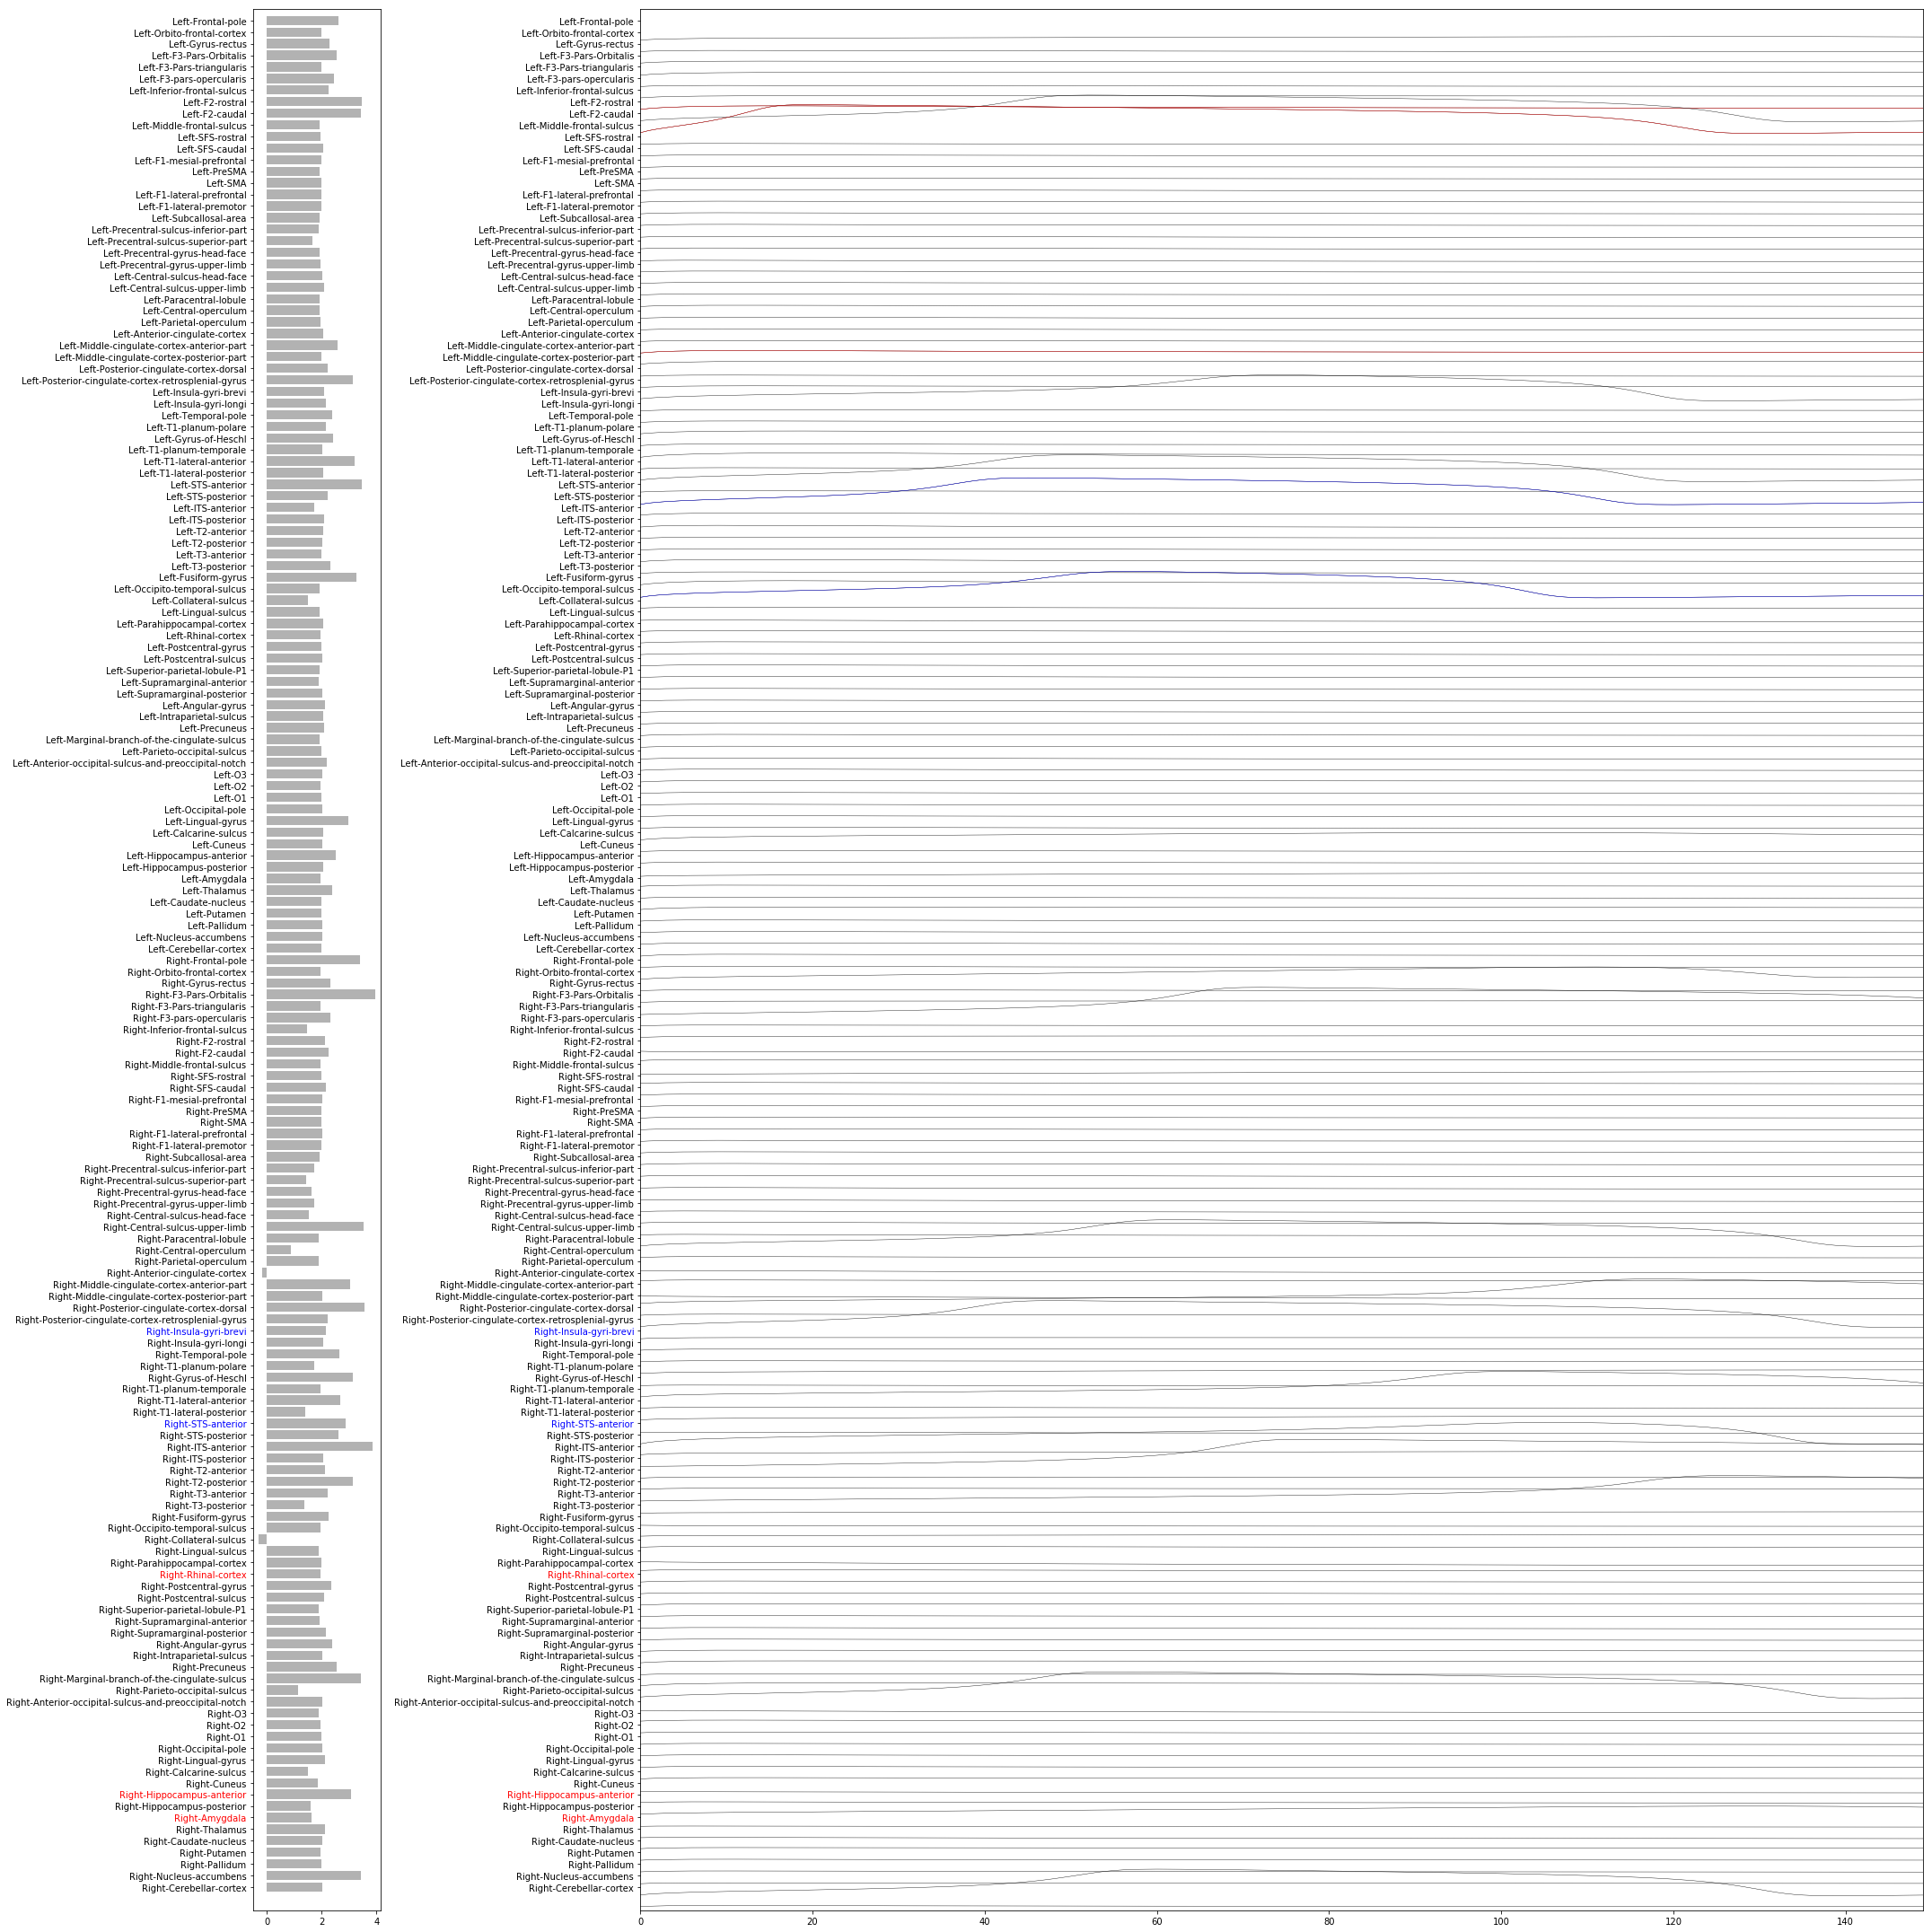

In [44]:
#lib.plots.stan.x0_violin_patient(pstr_samples['x0'], ez_hyp, figsize=(30,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}_chain{chain_no}.png')
figsize = [30,30]
x0_infer = pstr_samples['x0']
ns = x0_infer.shape[1]
plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1,2,width_ratios = [1,10])

ax=plt.subplot(gs[0,0])
plt.barh(np.arange(0, ns), x0_infer[0]+5, color='black', alpha=0.3)
plt.yticks(np.r_[:len(roi)], roi[::-1]);

for ichanvep in ezh_all[patient_id]['i_ez']:
            plt.gca().get_yticklabels()[161-ichanvep].set_color('red')
for ichanvep in ezh_all[patient_id]['i_pz']:
            plt.gca().get_yticklabels()[161-ichanvep].set_color('blue')

plt.ylim([-2,ns])
ax2=plt.subplot(gs[0,1])
scaleplt=3
TimeSeries = pstr_samples['x'].mean(axis=0).T
TS = np.arange(np.shape(TimeSeries)[1])
for i in range(ns)[::-1]:
    plt.plot(TS, scaleplt*TimeSeries[i]/np.ptp(TimeSeries) + i, 'black', lw=0.4);
    if i in ind_ez:
        plt.plot(TS, scaleplt*TimeSeries[i]/np.ptp(TimeSeries) + i, 'red', lw=0.4);
    if i in ind_pz:
        plt.plot(TS, scaleplt*TimeSeries[i]/np.ptp(TimeSeries) + i, 'blue', lw=0.4);
plt.yticks(np.r_[:len(roi)], roi[::-1]);
for ichanvep in ind_ez:
            plt.gca().get_yticklabels()[161-ichanvep].set_color('red')
for ichanvep in ind_pz:
            plt.gca().get_yticklabels()[161-ichanvep].set_color('blue')


plt.ylim([-2,ns])
plt.xlim([0,TS[-1]])
plt.tight_layout()


In [16]:
ez_hyp = ezh_all[patient_id]['i_ez']

In [17]:
ezh_all[patient_id]['i_ez']
pz_hyp = ezh_all[patient_id]['i_pz']

In [27]:
np.shape(pstr_samples['mu_slp'].mean(axis=0))

(150, 79)

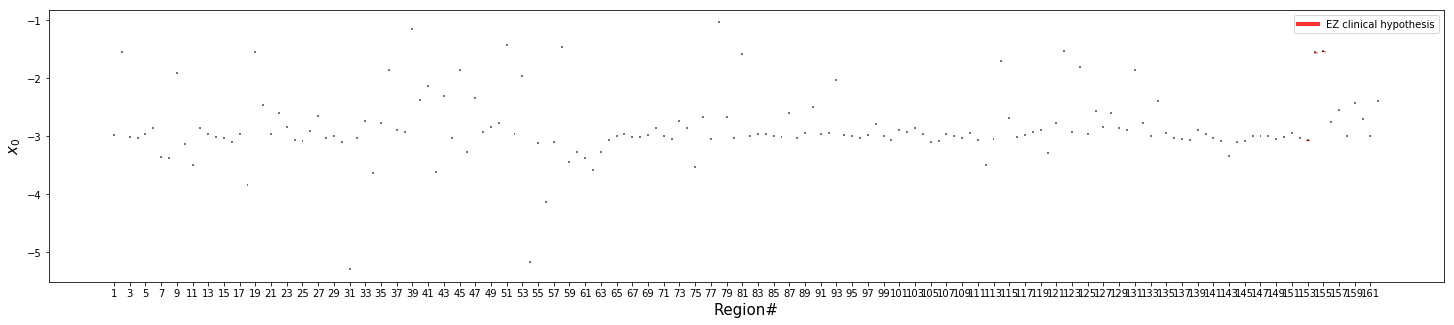

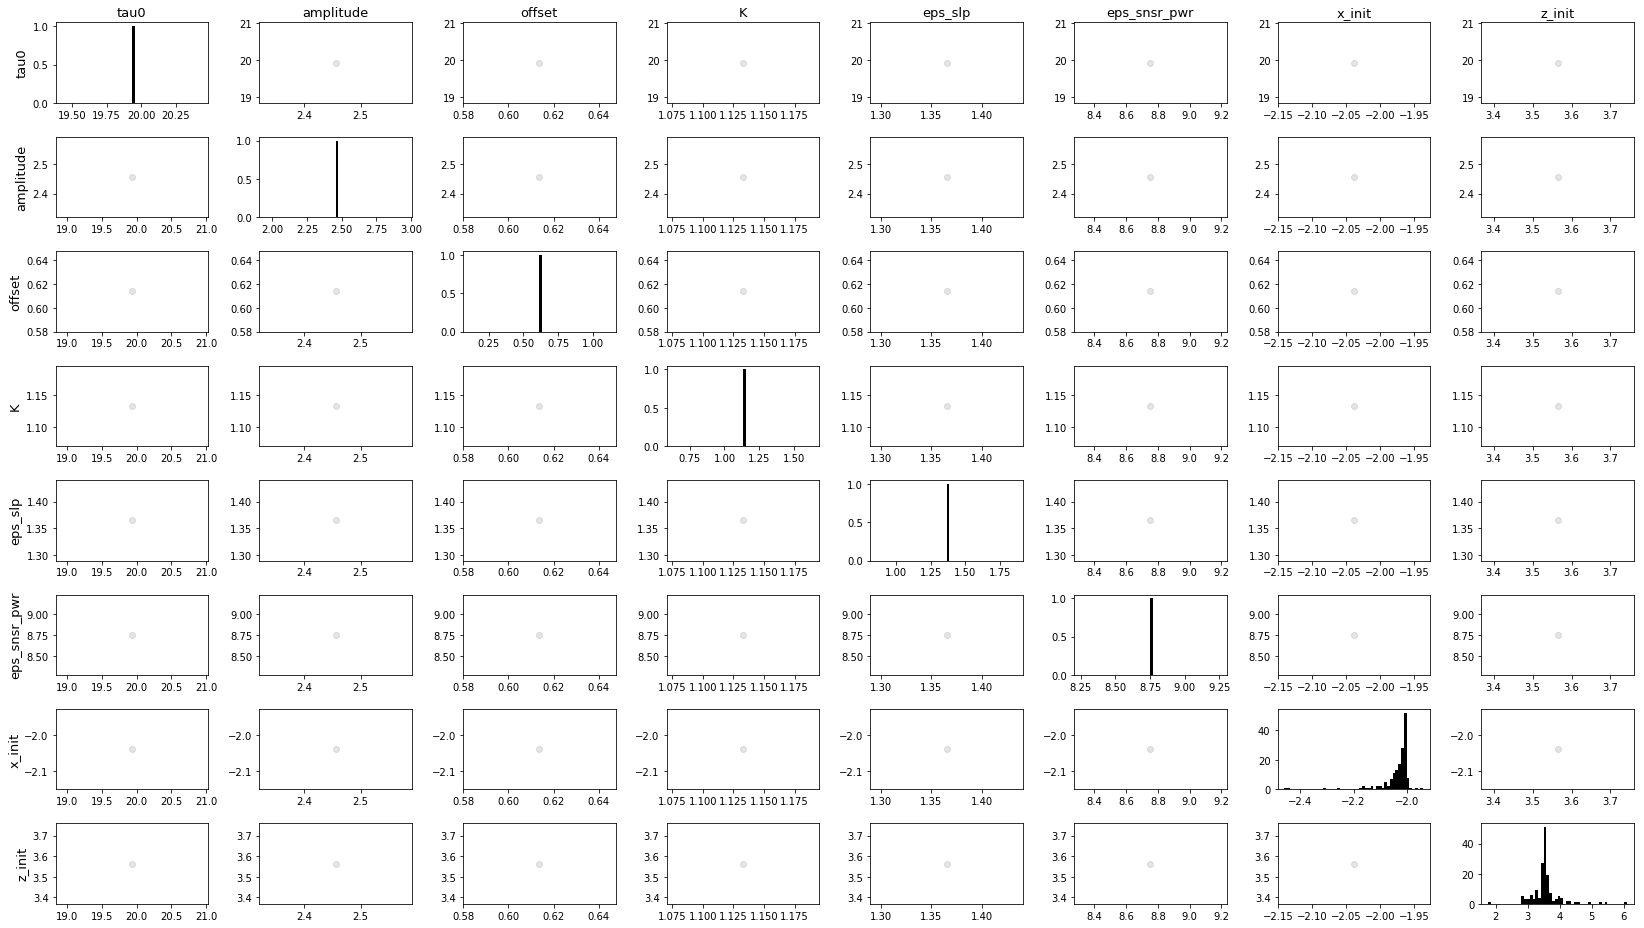

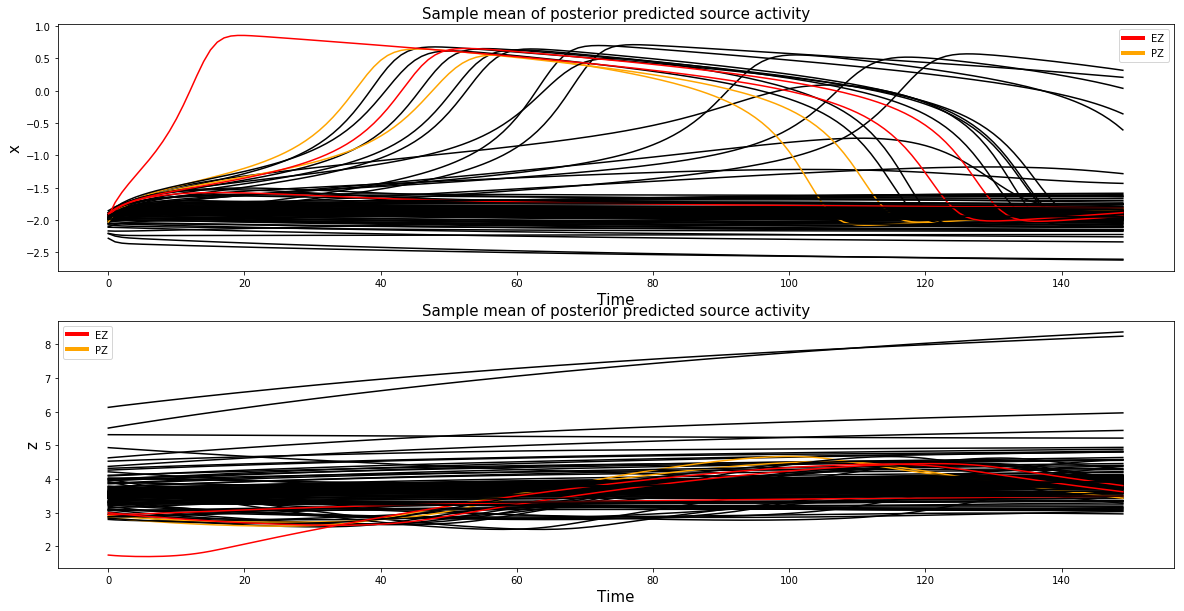

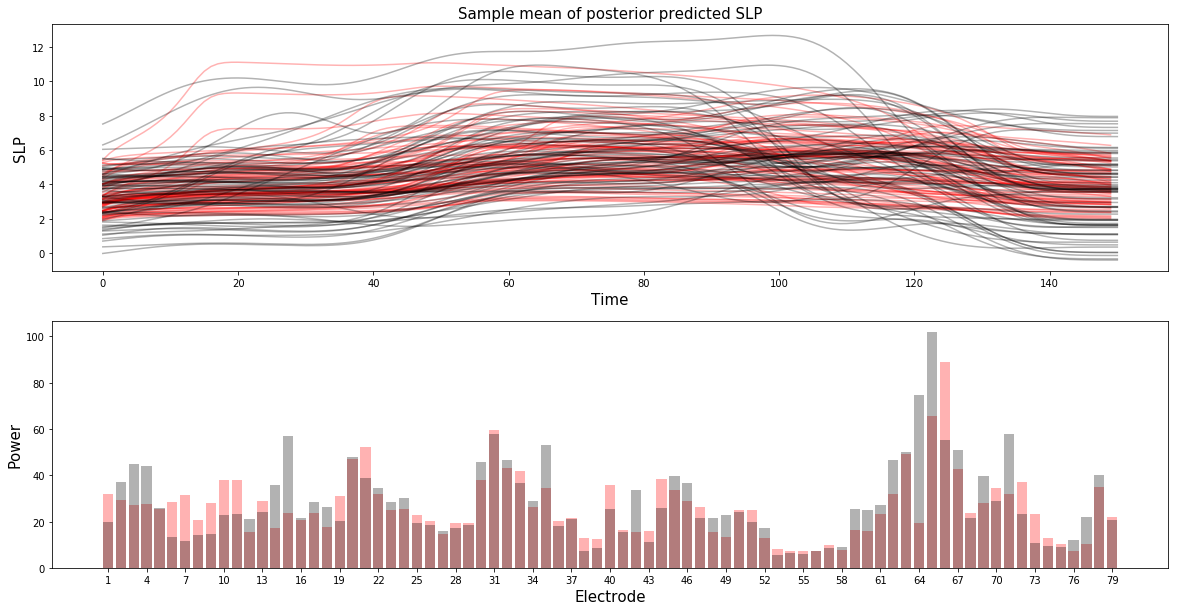

In [26]:
# import importlib
# importlib.reload(lib.plots.stan)

# ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.destrieux.txt') == 1)[0]
#chains = [1,2,3,4]
chains = [1]
for i,chain_no in enumerate(chains):
    pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{chain_no}.csv'])
    lib.plots.stan.x0_violin_patient(pstr_samples['x0'], ez_hyp, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}_chain{chain_no}.png')
    lib.plots.stan.pair_plots(pstr_samples, ['tau0', 'amplitude', 'offset', 'K', 'eps_slp', 'eps_snsr_pwr', 'x_init', 'z_init'],
                              figname=f'{results_dir}/figures/params_pair_plots_{fname_suffix}_chain{chain_no}.png')
    lib.plots.stan.plot_source(pstr_samples['x'].mean(axis=0), pstr_samples['z'].mean(axis=0), ez_hyp, pz_hyp,
                               figname=f'{results_dir}/figures/posterior_predicted_src_{fname_suffix}_chain{chain_no}.png')
    #lib.plots.stan.plot_feature(pstr_samples['mu_slp'].mean(axis=0),ez_hyp, pz_hyp,
                               #figname=f'{results_dir}/figures/posterior_predicted_muslp_{fname_suffix}_chain{chain_no}.png', giveylable='out slp', givetitle='Predictive slp')
    lib.plots.stan.plot_fit_target({'slp':pstr_samples['mu_slp'].mean(axis=0), 'snsr_pwr':pstr_samples['mu_snsr_pwr'].mean(axis=0)},
                                   data, figname=f'{results_dir}/figures/posterior_predicted_slp_{fname_suffix}_chain{chain_no}.png')



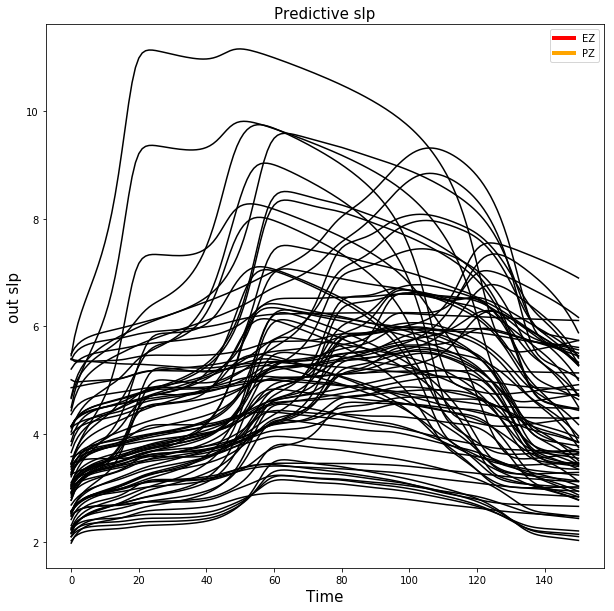

In [19]:
lib.plots.stan.plot_feature(pstr_samples['mu_slp'].mean(axis=0),ez_hyp, pz_hyp,
                               figname=f'{results_dir}/figures/posterior_predicted_muslp_{fname_suffix}_chain{chain_no}.png', giveylable='out slp', givetitle='Predictive slp')

In [22]:
np.shape(pstr_samples['mu_slp'])

(1, 151, 79)

In [21]:
pz_hyp

[113, 121]